## **Genre classification using Lyrics and Metadata**

### Libraries and Data Loading

1. **Libraries**  
   Import essential libraries for data manipulation, visualization, NLP, and machine learning, including `pandas`, `nltk`, `scikit-learn`, and `seaborn`.

2. **NLTK Setup**  
   Download necessary NLTK data files for text processing, such as stopwords, WordNet, and sentiment lexicons.

3. **Data Loading**  
   Load datasets (`id_genres`, `id_metadata`, and `id_lang`) from the specified paths using `pandas.read_csv()`.

4. **Lyrics Loading Function**  
   Define `load_lyrics()` to extract lyrics from a ZIP file:
   - Open the ZIP archive and read the specified number of text files.
   - Extract song IDs and lyrics, then store them in a dictionary.

5. **Load and Merge Lyrics**  
   Load lyrics data using the `load_lyrics()` function and create a DataFrame.
   - Merge the lyrics DataFrame with genre, metadata, and language data into a single `data` DataFrame using the `merge()` method.

This section sets up the environment, loads the required libraries, and prepares the merged dataset for further analysis and modeling.


In [67]:
# Standard Libraries
import os
import re
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity

# Text Processing and Natural Language Processing (NLP)
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Machine Learning - Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# Machine Learning - Other Libraries
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 

# NLP Text Analysis
from textblob import TextBlob

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)
        
# Load data
id_genres = pd.read_csv('D:/University of Sheffield/Final Project/Datasets/Test/music4all_no_audio/music4all_no_audio/id_genres.csv', sep='\t')
id_metadata = pd.read_csv('D:/University of Sheffield/Final Project/Datasets/Test/music4all_no_audio/music4all_no_audio/id_metadata.csv', sep='\t')
id_lang = pd.read_csv('D:/University of Sheffield/Final Project/Datasets/Test/music4all_no_audio/music4all_no_audio/id_lang.csv', sep='\t')


In [68]:
# Function to load lyrics
def load_lyrics(lyrics_zip_path, num_files):
    lyrics_dict = {}

    # Open the ZIP file
    with zipfile.ZipFile(lyrics_zip_path, 'r') as zip_ref:
        # Get the list of files in the ZIP archive
        files = zip_ref.namelist()[:num_files]

        for file in tqdm(files, desc="Loading lyrics"):
            # Open and read each file
            with zip_ref.open(file) as f:
                lyrics = f.read().decode('utf-8').strip()

                song_id = os.path.basename(file).replace('.txt', '')
                lyrics_dict[song_id] = lyrics

    return lyrics_dict

# Path to the ZIP file
lyrics_zip_path = 'D:/University of Sheffield/Final Project/Datasets/Test/music4all_no_audio/music4all_no_audio/lyrics.zip'

# Load lyrics
lyrics_dict = load_lyrics(lyrics_zip_path, num_files=109269)

# Create a DataFrame from the lyrics dictionary
lyrics_df = pd.DataFrame(list(lyrics_dict.items()), columns=['id', 'lyrics']) 

# Merge data
data = lyrics_df.merge(id_genres, on='id', how='inner')\
                .merge(id_metadata, on='id', how='inner')\
                .merge(id_lang, on='id', how='inner')
data

Loading lyrics: 100%|███████████████████████████████████████████████████████| 109269/109269 [00:04<00:00, 24512.55it/s]


,id,lyrics,genres,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms,lang
0,0009fFIM1eYThaPg,"It's a sunny day, so I got nowhere to hide\nNo...",pop,3eObKIfHKJ1nAPh0wTxFCc,12.0,2009,0.635,0.746,6.0,1.0,0.548,110.973,229947,en
1,0010xmHR6UICBOYT,You might think my words are gift wrapped\nPut...,underground hip hop,27szvF97Tu95GxN98N52fy,46.0,2013,0.591,0.513,7.0,0.0,0.263,172.208,325096,en
2,002Jyd0vN4HyCpqL,Goering's on the phone to Freiburg\nSay's Will...,"hard rock,rock,classic rock",273lBFpxUCwisTpdnF9cVb,31.0,1974,0.319,0.925,2.0,1.0,0.658,157.630,285693,en
3,006TYKNjNxWjfKjy,My princess why must I assist at your death\nI...,"symphonic metal,power metal,symphonic power metal",1qZgergQ41vaD4zBf3AKXR,33.0,2017,0.432,0.979,7.0,1.0,0.162,90.008,332867,en
4,007LIJOPQ4Sb98qV,Absorbing your words\nBattles raging within me...,"post-punk,new wave",6rVxJ3sN3Cz40MSLavbG1K,19.0,2009,0.357,0.708,9.0,1.0,0.470,123.904,326067,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109264,zzz0n04uuTUA7fNh,Girl you don't know how I feel (how I really f...,pop,21pCToQdqcPi879auxjxKe,48.0,2014,0.572,0.503,6.0,0.0,0.553,103.215,262840,en
109265,zzzj3LYaZtYtbzSr,"wwI, oh, must go on standing\nYou can't break ...",singer-songwriter,2SJ6FGmRPacKE9N4g4BRZU,21.0,2010,0.402,0.376,2.0,0.0,0.119,108.509,276507,en
109266,zzznMjZAKnJJXQSj,Talkin' in my sleep at night\nMakin' myself cr...,"synthpop,remix,pop",2ygfHXyt3gvyhvKrNJU61n,47.0,2017,0.532,0.977,10.0,0.0,0.966,116.527,224549,en
109267,ZZZS8RD8VFhzYLJ6,Men in white coats\nRing the changes\nCall us ...,"new wave,post-punk",7EMoSEOUoS90lQdXll2mak,13.0,2010,0.528,0.826,0.0,1.0,0.182,123.012,299746,en


## Text Pre-Processing Pipeline

- **Setup**: Initialize `stop_words` and `lemmatizer` to standardize text preprocessing steps.

- **Cleaning Lyrics**: 
  - Convert lyrics to lowercase.
  - Remove numbers, punctuation, and extra spaces.
  - Tokenize, lemmatize, and remove stop words.

- **Additional Cleaning**: 
  - Exclude instrumental pieces and non-ASCII characters.
  - Remove empty or null lyrics entries.
  - Filter the dataset to include only English-language songs.

- **Remove Repetitions**: 
  - Eliminate repeated lines or words to reduce redundancy.

- **Sentiment Analysis**: 
  - Calculate sentiment polarity of each song using `TextBlob`.

- **Create Processed DataFrame**: 
  - Merge cleaned lyrics with language data and apply the above cleaning functions.

- **Output**: 
  - Display the size and preview of the cleaned DataFrame to verify preprocessing results.


In [69]:

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to process Lyrics
def clean_lyrics(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # Lemmatize the words first
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word not in stop_words)

# Function to apply additional cleaning steps
def additional_cleaning_steps(df):
    # Remove any songs without lyrics (e.g., instrumental pieces)
    df = df[df['lyrics'].str.strip().str.lower() != 'instrumental']
    # Remove corrupted/non-ASCII characters
    df = df[~df['lyrics'].str.contains(r'[^\x00-\x7F]+')]
    # Remove empty lyrics
    df = df[df['lyrics'].str.strip() != '']
    # Remove null values
    df = df.dropna(subset=['lyrics'])
    # Filter to keep only rows where 'lang' is 'en' (English)
    df = df[df['lang'] == 'en']
    return df

# Function to remove repetitions in lyrics
def remove_repetitions(text):
    words = text.split()
    return ' '.join(sorted(set(words), key=words.index))

def get_sentiment(text):
    # Calculate sentiment polarity using TextBlob
    return TextBlob(text).sentiment.polarity

# Create a DataFrame from the lyrics dictionary
lyrics_df = pd.DataFrame(list(lyrics_dict.items()), columns=['id', 'lyrics'])

# Apply the cleaning function to the lyrics column
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(clean_lyrics)

# Remove repeated lines in lyrics
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(remove_repetitions)

# Merge the language information into lyrics_df
lyrics_df = pd.merge(lyrics_df, data[['id', 'lang']], on='id', how='left')

# Apply additional cleaning steps
lyrics_df = additional_cleaning_steps(lyrics_df)

# Calculate sentiment for each song
lyrics_df['sentiment'] = lyrics_df['lyrics'].apply(get_sentiment)

# Print the final DataFrame shape and a sample of the results
print(f"Number of records in lyrics_df: {len(lyrics_df)}")
print(lyrics_df.shape)
print(lyrics_df.head())

Number of records in lyrics_df: 82457
(82457, 4)
                 id                                             lyrics lang  \
0  0009fFIM1eYThaPg  sunny day got nowhere hide cloud sky im preten...   en   
1  0010xmHR6UICBOYT  might think words gift wrapped putting positiv...   en   
2  002Jyd0vN4HyCpqL  goerings phone freiburg says willies done quit...   en   
3  006TYKNjNxWjfKjy  princess must assist death cant endure tragic ...   en   
4  007LIJOPQ4Sb98qV  absorbing words battles raging within graduall...   en   

   sentiment  
0   0.074256  
1  -0.043766  
2   0.009264  
3  -0.039000  
4  -0.021429  


## Genre Embedding with GloVe

### Loading GloVe Model
- **Path Setup**: Define the base directory and the path to the GloVe file (`glove.6B.100d.txt`).
- **Load Embeddings**: Load the GloVe embeddings into a dictionary `glove_embeddings` with words as keys and their vectors as values.

### Genre Extraction
- **Extract Genres**: Extract all genres from the dataset by splitting the genre strings and removing duplicates.

### Genre Embedding Function
- **Function**: `get_genre_embedding(genre_name, glove_embeddings)` computes the average embedding for each genre name.
  - **Process**:
    - Split genre names into words, convert to lowercase.
    - Fetch corresponding embeddings for each word from GloVe.
    - Return the mean of these embeddings or a zero vector if no words are found in the GloVe model.

### Creating Genre Embeddings
- **Embedding Creation**: Convert all extracted genres into their respective embeddings using the `get_genre_embedding` function.
- **Output**: The genre embeddings are stored as a NumPy array for further use in clustering or other analyses.


In [50]:

# ---  Load the GloVe model ---
BASE_DIR = 'D:/University of Sheffield/Final Project/Datasets/Test'
GLOVE_PATH = os.path.join(BASE_DIR, 'glove.6B', 'glove.6B.100d.txt')

glove_embeddings = {}
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        glove_embeddings[word] = np.array(vector, dtype=np.float32)


all_genres = []
for genres_string in id_genres['genres']:
    all_genres.extend([genre.strip() for genre in genres_string.split(',')])
all_genres = list(set(all_genres))  # Ensure unique genres

# --- Genre Embedding Function ---
def get_genre_embedding(genre_name, glove_embeddings):
    words = genre_name.lower().split()
    embeddings = [glove_embeddings[w] for w in words if w in glove_embeddings]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        print(f"Genre not found in embeddings: {genre_name}")
        return np.zeros(next(iter(glove_embeddings.values())).shape)

# --- Create Genre Embeddings (convert to NumPy array) --- 
genre_embeddings = np.array([get_genre_embedding(genre, glove_embeddings) for genre in all_genres])



Genre not found in embeddings: jumpstyle
Genre not found in embeddings: electropunk
Genre not found in embeddings: trancecore
Genre not found in embeddings: indietronica
Genre not found in embeddings: rawstyle
Genre not found in embeddings: emocore
Genre not found in embeddings: shibuya-kei
Genre not found in embeddings: j-indie
Genre not found in embeddings: tecnobrega
Genre not found in embeddings: folktronica
Genre not found in embeddings: nintendocore
Genre not found in embeddings: c-pop
Genre not found in embeddings: austropop
Genre not found in embeddings: chalga
Genre not found in embeddings: volksmusik
Genre not found in embeddings: blackgaze
Genre not found in embeddings: liedermacher
Genre not found in embeddings: filthstep
Genre not found in embeddings: pornogrind
Genre not found in embeddings: chillwave
Genre not found in embeddings: neurofunk
Genre not found in embeddings: louvor
Genre not found in embeddings: adoracao
Genre not found in embeddings: batida
Genre not found 

## Genre Clustering with K-Means and Visualization

### Clustering with K-Means
- **Setup**: Define the number of clusters (`n_clusters = 11`) and initialize the KMeans algorithm with 11 clusters.
- **Fit Model**: Apply KMeans clustering on the genre embeddings created from GloVe vectors.
- **Output**: Obtain cluster labels for each genre, indicating which cluster each genre belongs to.

### Visualization with t-SNE
- **Dimensionality Reduction**: Use t-SNE to reduce the high-dimensional genre embeddings to 2D for visualization purposes.
- **Plotting**: 
  - Scatter plot each genre's 2D embedding, colored by its assigned cluster.
  - Add titles and legends to differentiate the clusters visually.
- **Output**: The plot visually represents how genres are grouped into clusters.

### Inspection and Adjustment of Clusters
- **DataFrame Creation**: Create a DataFrame to inspect the genres and their corresponding clusters.
- **Grouping**: Group genres by clusters for easy inspection.
- **Output**: Display grouped genres within each cluster to aid in manual adjustments or further analysis.


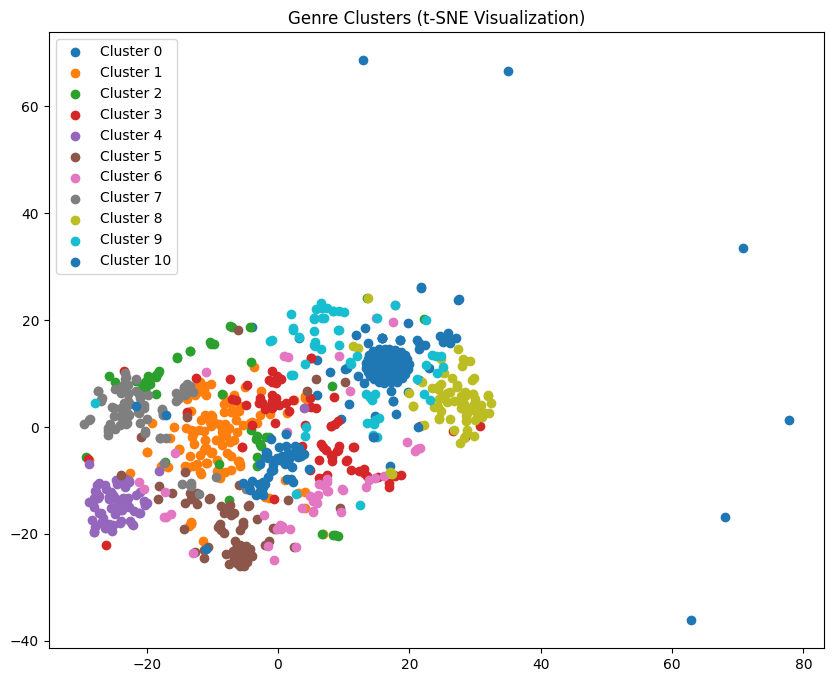

Cluster
0     [jumpstyle, electropunk, shred, trancecore, k-...
1     [boston hardcore, comedy, houston rap, pop, ar...
2     [tribute, anime, comic, irish folk, free folk,...
3     [reggae fusion, roots reggae, cumbia pop, skin...
4     [spanish metal, folk metal, finnish black meta...
5     [outlaw country, straight edge, tropical house...
6     [atmosphere, sleep, abstract, drone, space amb...
7     [latin hip hop, chinese hip hop, romanian pop,...
8     [nerdcore, electroclash, afropop, k-pop, mando...
9     [tejano, carnaval, bebop, boogaloo, bachata, m...
10    [dark jazz, texas blues, memphis blues, jump b...
Name: Genre, dtype: object


In [51]:
# --- Clustering Using KNN---
n_clusters = 11  
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  # Set n_init explicitly
kmeans.fit(genre_embeddings)
cluster_labels = kmeans.labels_

# --- Visualization (using t-SNE for dimensionality reduction) --- 
tsne = TSNE(n_components=2, random_state=42) 
embeddings_2d = tsne.fit_transform(genre_embeddings)

plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(embeddings_2d[cluster_labels == i, 0], 
                embeddings_2d[cluster_labels == i, 1], 
                label=f'Cluster {i}')

plt.title('Genre Clusters (t-SNE Visualization)')
plt.legend()
plt.show()

# --- Create DataFrame for inspection and manual adjustment ---
df = pd.DataFrame({'Genre': all_genres, 'Cluster': cluster_labels})
print(df.groupby('Cluster')['Genre'].apply(list))

## Genre Hierarchy and Parent Genre Assignment

### Genre Hierarchy
- **Purpose**: Assign a parent genre to each child genre to create a hierarchical structure for genre classification.
- **Structure**: The hierarchy categorizes genres into broad parent genres with specific sub-genres under each category.

### Steps

1. **Flatten Genre Hierarchy**:
   - Create a mapping (`genre_to_parent`) that associates each specific genre with its parent genre.
   - Iterate through the hierarchy to build this mapping.

2. **Assign Parent Genres**:
   - Define a function to map each genre in the dataset to its parent genre using the `genre_to_parent` mapping.
   - Handle cases where multiple parent genres might apply by returning a comma-separated list.

3. **Apply Assignment**:
   - Apply the function to the `id_genres` DataFrame to add a new column (`parent_genre_new`) with the assigned parent genres.

### Output
- **DataFrame**: Updated `id_genres` DataFrame with a new column for the parent genre of each entry.



In [52]:
# Genre Hierarchy is used to assign parent level Genre to all child level genre 

genre_hierarchy = {
    'Rock' : {
    'Hardcore/Punk': ['hardcore punk', 'punk', 'melodic hardcore', 'hardcore', 'grindcore', 'pop punk', 'screamo', 'anarcho-punk', 'oi', 'straight edge', 'hardcore punk', 'post-hardcore', 'mathcore', 'skate punk', 'crust punk', 'power violence', 'dark hardcore', 'riot grrrl', 'chaotic hardcore', 'nyhc', 'dc hardcore', 'boston hardcore', 'easycore', 'post-screamo', 'nintendocore'], 
    'Progressive/Experimental Metal': ['djent', 'stoner rock', 'post-rock', 'krautrock', 'space rock', 'psychedelic doom', 'gothic doom', 'atmospheric doom', 'progressive doom', 'funeral doom'], 
    'Classic/Hard Rock': ['classic rock', 'hard rock', 'glam rock', 'blues-rock', 'sleaze rock', 'heartland rock', 'southern rock', 'pub rock', 'album rock', 'modern hard rock', 'christian hard rock', 'melodic hard rock'], 
    'Alternative/Indie Rock': ['post-punk', 'new wave', 'indie rock', 'shoegaze', 'alternative rock', 'lo-fi', 'garage rock', 'dream pop', 'britpop', 'grunge', 'spanish rock', 'gothic rock', 'madchester', 'no wave', 'noise rock', 'j-rock', 'folk rock', 'emo', 'alternative pop', 'indie folk', 'brazilian rock', 'post-grunge', 'noise pop', 'rock nacional', 'new weird america', 'jangle pop', 'country rock', 'emo punk', 'folk punk', 'math rock', 'rockabilly', 'indie punk', 'punk blues', 'freakbeat', 'shoegaze', 'dream pop', 'dark wave', 'slowcore', 'emo', 'twee pop', 'chamber pop', 'jangle pop', 'post-rock', 'noise pop', 'indie pop', 'dreamgaze', 'surf music', 'anti-folk', 'c86', 'garage pop', 'nu gaze', 'grunge pop', 'cowpunk', 'noise punk', 'jangle rock']
    },
    
    'Metal' : {
    'Heavy Metal': [ 'atmospheric sludge', 'crossover thrash', 'blackened hardcore', 'black thrash', 'black death','symphonic metal', 'gothic metal', 'power metal', 'death metal', 'thrash metal', 'speed metal', 'black metal', 'viking metal', 'folk metal', 'melodic death metal', 'brutal death metal', 'technical death metal', 'symphonic black metal', 'atmospheric black metal', 'melodic black metal', 'depressive black metal', 'raw black metal', 'swedish black metal', 'finnish black metal', 'norwegian black metal', 'canadian black metal', 'greek black metal', 'polish black metal', 'technical brutal death metal', 'industrial black metal', 'symphonic death metal', 'progressive black metal', 'swedish death metal', 'drone metal', 'experimental black metal', 'avant-garde black metal', 'cosmic black metal', 'gothic symphonic metal', 'technical black metal', 'sludge metal'], 
    'Hardcore/Punk': ['metalcore', 'nu metal', 'metallic hardcore'], 
    'Progressive/Experimental Metal': ['progressive metal', 'doom metal', 'drone metal', 'post-metal', 'stoner metal', 'instrumental progressive metal', 'post-black metal', 'sludge metal', 'dub metal'], 
    'Classic/Hard Rock': ['glam metal']
    },

    'Electronic/Dance': {
        'House/Techno': ['trance', 'techno', 'house', 'electro', 'minimal techno', 'minimal', 'electro house', 'deep house', 'tech house', 'progressive house', 'future house', 'minimal', 'breakbeat', 'eurodance', 'dub techno', 'fidget house', 'hip house', 'tribal house', 'deep vocal house', 'italo house', 'acid techno', 'dutch house', 'uk house', 'disco house', 'jump up', 'hard house'], 
        'Trance/Psytrance': ['trance', 'vocal trance', 'progressive trance', 'hard trance', 'psychedelic trance', 'uplifting trance', 'goa trance', 'deep progressive trance'],
        'Ambient/Chillwave': ['ambient', 'downtempo', 'chillwave', 'electronica', 'dark ambient', 'ambient techno', 'space ambient', 'ambient industrial', 'experimental ambient', 'deep ambient', 'dronescape'],
        'EDM': ['edm', 'big room', 'trap music', 'complextro', 'dubstep', 'brostep', 'electro house', 'trap latino', 'future bass', 'moombahton', 'bass music', 'wonky'], 
        'Drum & Bass/Breakbeat': ['drum and bass', 'breakcore', 'jungle', 'breakbeat', 'breaks', 'ragga jungle', 'drill and bass', 'hardcore breaks'],
        'Electro/Industrial': ['electroclash', 'ebm', 'electro-industrial', 'aggrotech', 'industrial metal', 'industrial', 'industrial rock', 'futurepop', 'power noise', 'digital hardcore', 'martial industrial', 'cyber metal'],
        'Other Electronic': ['synthpop', 'electropop', 'nu disco', 'disco', 'chiptune', 'video game music', '8-bit', 'c64', 'retro electro', 'electro swing']
    },
    
    'Pop': {
        'Mainstream Pop': ['pop', 'k-pop', 'j-pop', 'teen pop', 'bubblegum pop', 'eurovision', 'french pop', 'portuguese pop', 'italian pop', 'spanish pop', 'uk pop', 'mexican pop', 'albanian pop', 'bulgarian pop', 'greek pop', 'kazakh pop', 'lithuanian pop', 'polish pop', 'romanian pop', 'russian pop', 'swedish pop', 'taiwan pop', 'turkish pop', 'talent show', 'girl group', 'boy band', 'idol', 'bedroom pop', 'operatic pop', 'baroque pop', 'sunshine pop'], 
        'Country Pop': ['country', 'contemporary country', 'country pop', 'mpb', 'sertanejo'], 
        'Latin Pop': ['latin pop', 'reggaeton', 'bachata', 'merengue']
    },
    'World Music': {
        'Latin': ['salsa', 'samba', 'forro', 'latin', 'cumbia', 'ranchera', 'tejano', 'vallenato', 'bolero', 'morna', 'tropical', 'brega', 'pagode', 'cumbia villera', 'grupera', 'sertanejo universitario', 'cumbia chilena', 'cumbia pop', 'salsa cubana', 'latin jazz', 'choro', 'bossa nova', 'tecnobrega', 'nueva cancion', 'mariachi', 'flamenco', 'rumba', 'bachata', 'merengue', 'batida'],
        'Celtic': ['celtic', 'celtic rock', 'celtic metal', 'irish folk', 'scottish folk'],
        'Other World': ['world', 'afrobeat', 'bhangra', 'punjabi', 'rai', 'opm', 'turkish pop', 'turkish folk', 'afrikaans', 'nova mpb', 'celtic', 'mandopop', 'gamelan', 'klezmer'] # Add other world music subgenres here 
    },
    'Urban/Hip-Hop': {
        'Hip-Hop': ['hip hop', 'underground hip hop', 'rap', 'crunk', 'southern hip hop', 'emo rap', 'trap music', 'gangster rap', 'hardcore hip hop', 'turntablism', 'alternative hip hop', 'experimental hip hop', 'country rap', 'new jack swing', 'pop rap', 'ska punk', 'horrorcore', 'nerdcore', 'abstract hip hop', 'east coast hip hop', 'houston rap', 'irish hip hop', 'nigerian hip hop', 'polish hip hop', 'french hip hop', 'chinese hip hop', 'uk hip hop', 'spanish hip hop', 'latin hip hop', 'trap argentino', 'bounce', 'meme rap'], 
        'R&B': ['rhythm and blues']
    },
    'R&B/Soul': {
        'Soul': ['soul', 'classic soul', 'northern soul', 'motown', 'smooth soul', 'neo soul', 'philly soul', 'southern soul', 'swedish soul', 'chicago soul', 'retro soul', 'lovers rock', 'quiet storm'],
        'Funk': ['funk', 'funk metal', 'funk rock', 'jazz funk', 'deep funk', 'funk carioca', 'gospel funk', 'afro-funk']
    },
    'Folk & Traditional': {
        'Folk': ['folk', 'ambient folk', 'indie folk', 'folk rock', 'folk punk', 'folk-pop', 'psychedelic folk', 'freak folk', 'free folk', 'nordic folk', 'contemporary folk', 'british folk', 'american folk', 'celtic folk', 'medieval folk'], 
        'Singer-Songwriter': ['singer-songwriter', 'cantautor'], 
        'Bluegrass': ['bluegrass', 'progressive bluegrass']
    },
    'Classical & Instrumental': {
        'Classical': ['classical', 'contemporary classical', 'neoclassical', 'neo-classical', 'early music', 'renaissance', 'baroque', 'piano', 'orchestral', 'chamber music'],
        'Jazz': ['jazz', 'bebop', 'free jazz', 'jazz fusion', 'avant-garde jazz', 'vocal jazz', 'jazz piano', 'nu jazz', 'jazz blues', 'jazz metal', 'jazz rap', 'latin jazz', 'avant-garde jazz', 'smooth jazz', 'cool jazz', 'acid jazz', 'jazz funk', 'new orleans jazz', 'gypsy jazz', 'spiritual jazz', 'french jazz', 'polish jazz', 'ethio-jazz', 'jazz trio', 'jazz guitar', 'jazz violin', 'jazz saxophone', 'jazz trumpet'],
        'Instrumental': ['accordion', 'banjo', 'harp', 'violin', 'cello', 'sitar', 'harpsichord', 'instrumental rock', 'guitar', 'piano', 'strings']
    },
    'Blues & Jazz': {
        'Blues': ['blues', 'electric blues', 'delta blues', 'chicago blues', 'country blues', 'swamp blues', 'piedmont blues', 'gospel blues', 'harmonica blues', 'jump blues', 'punk blues', 'modern blues'],
        'Jazz': ['jazz', 'bebop', 'free jazz', 'jazz fusion', 'avant-garde jazz', 'vocal jazz', 'big band', 'swing', 'ragtime', 'jazz piano', 'nu jazz', 'acid jazz', 'jazz funk', 'new orleans jazz']
    },
    'Experimental & Avant-Garde': {
        'Experimental': ['experimental', 'drone', 'free improvisation', 'noise', 'witch house', 'minimal wave', 'avant-garde', 'noise rock', 'experimental hip hop', 'experimental rock', 'experimental pop', 'experimental electronic', 'experimental ambient', 'musique concrete', 'sound collage', 'lowercase'],
        'Avant-Garde': ['avant-garde', 'free jazz', 'avant-garde jazz', 'avant-garde metal']
    },
    'Stage & Screen': {
        'Soundtrack': ['soundtrack'],
        'Broadway': ['broadway'],
        'Disney': ['disney'],
        'Video Game Music': ['video game music', 'chiptune', '8-bit']
    },
    'Other': {
        'Spoken Word': ['spoken word', 'poetry', 'comedy'],
        'Religious': ['christian rock', 'gospel', 'praise', 'worship', 'christian metal', 'christian pop', 'christian hardcore', 'ccm', 'gospel', 'christian music', 'worship', 'adoracao', 'lds'],
        'Miscellaneous': ['easy listening', 'lounge', 'new age', 'beats', 'axe', 'football', 'halloween', 'christmas', 'meditation', 'yoga', 'sleep', 'tone', 'motivation', 'guidance', 'healing', 'lullaby', 'ringtone', 'theme']
    }
}

# Step 1: Flatten the genre hierarchy
genre_to_parent = {}

for parent, subcategories in genre_hierarchy.items():
    for subcategory, genres in subcategories.items():
        for genre in genres:
            genre_to_parent[genre] = parent

# Step 2: Assign parent genre based on the genres in the dataset
def assign_parent_label(genres_str):
    genres = genres_str.split(',')
    parent_labels = set()
    
    for genre in genres:
        genre = genre.strip().lower()
        if genre in genre_to_parent:
            parent_labels.add(genre_to_parent[genre])
    
    # If multiple parent labels, we can return them as a list, or a string concatenated with commas
    return ','.join(parent_labels) if parent_labels else 'Unknown'

# Apply the function to the dataframe
id_genres['parent_genre_new'] = id_genres['genres'].apply(assign_parent_label)

print(df)


               Genre  Cluster
0    boston hardcore        1
1     outlaw country        5
2           nerdcore        8
3             tejano        9
4      latin hip hop        7
..               ...      ...
848             ukhc        0
849    armenian folk        2
850      jazz violin       10
851              ska        3
852   symphonic rock        1

[853 rows x 2 columns]


## Filter DataFrame for Single Parent Genres

### Steps

1. **Filter Rows**:
   - Use a condition to select rows where the `parent_genre_new` column does not contain a comma.
   - This ensures that only rows with a single parent genre are retained.

2. **Display Results**:
   - Show the first few rows of the filtered DataFrame to verify the result.




In [53]:
# Filter out rows where 'parent_genre_new' contains a comma
filtered_id_genres = id_genres[~id_genres['parent_genre_new'].str.contains(',')]

# Display the first few rows of the filtered DataFrame
filtered_id_genres


,id,genres,parent_genre_new
0,0009fFIM1eYThaPg,pop,Pop
1,0010xmHR6UICBOYT,underground hip hop,Urban/Hip-Hop
2,002Jyd0vN4HyCpqL,"hard rock,rock,classic rock",Rock
3,006TYKNjNxWjfKjy,"symphonic metal,power metal,symphonic power metal",Metal
4,007LIJOPQ4Sb98qV,"post-punk,new wave",Rock
...,...,...,...
109262,zzx8CWdM7qkxKQpC,indie rock,Rock
109264,zzyyPUs7hC9Nz2e1,"hardcore punk,punk,hardcore",Rock
109265,zzz0n04uuTUA7fNh,pop,Pop
109266,zzzj3LYaZtYtbzSr,singer-songwriter,Folk & Traditional


## Drop Original Genres Column and Merge DataFrame

### Objective
- **Remove**: The `genres` column from the DataFrame.
- **Merge**: Combine the filtered DataFrame with the `lyrics_df` DataFrame.

### Steps

1. **Merge DataFrames**:
   - Merge `filtered_id_genres` with `lyrics_df` on the `id` column.

2. **Drop Column**:
   - Remove the `genres` column from the merged DataFrame.

3. **Display Results**:
   - Show the resulting DataFrame to verify the changes.

In [54]:
# Drop original genres columns from dataframe
merged_df = pd.merge(filtered_id_genres, lyrics_df, on='id', how='inner')
merged_df = merged_df.drop(columns=['genres'])
merged_df

,id,parent_genre_new,lyrics,lang,sentiment
0,0009fFIM1eYThaPg,Pop,sunny day got nowhere hide cloud sky im preten...,en,0.074256
1,0010xmHR6UICBOYT,Urban/Hip-Hop,might think words gift wrapped putting positiv...,en,-0.043766
2,002Jyd0vN4HyCpqL,Rock,goerings phone freiburg says willies done quit...,en,0.009264
3,006TYKNjNxWjfKjy,Metal,princess must assist death cant endure tragic ...,en,-0.039000
4,007LIJOPQ4Sb98qV,Rock,absorbing words battles raging within graduall...,en,-0.021429
...,...,...,...,...,...
62259,zzx8CWdM7qkxKQpC,Rock,innocence dont come easy sense never accidents...,en,-0.076915
62260,zzyyPUs7hC9Nz2e1,Rock,cant cut heart cold ground stood like tombston...,en,-0.215894
62261,zzz0n04uuTUA7fNh,Pop,girl dont know feel really since away oh baby ...,en,0.110823
62262,zzzj3LYaZtYtbzSr,Folk & Traditional,wwi oh must go standing cant break isnt im cho...,en,-0.400000


## Calculate and Print Genre Counts

### Objective
- **Calculate**: The number of occurrences for each genre in the `parent_genre_new` column.
- **Print**: Display the class distribution for genres.

### Steps

1. **Calculate Genre Counts**:
   - Use the `value_counts()` method to get the count of each unique genre in the `parent_genre_new` column.

2. **Print Results**:
   - Display the class distribution.

In [55]:
import pandas as pd

# Calculate and print the genre counts
genre_counts = merged_df['parent_genre_new'].value_counts()
print("Class Distribution:")
print(genre_counts)



Class Distribution:
parent_genre_new
Rock                          25436
Pop                            9454
Metal                          6656
Unknown                        4949
Electronic/Dance               4284
Folk & Traditional             3859
Urban/Hip-Hop                  2720
R&B/Soul                       2252
Blues & Jazz                    904
Experimental & Avant-Garde      797
Stage & Screen                  500
Other                           310
World Music                      83
Classical & Instrumental         60
Name: count, dtype: int64


In [56]:
# Checking for missing values
merged_df.isna().sum()

id                  0
parent_genre_new    0
lyrics              0
lang                0
sentiment           0
dtype: int64

## Calculate and Normalize Lyric Word Counts

### Objective
- **Calculate**: The word count for each lyric.
- **Normalize**: Adjust the word counts to a 0-1 range and scale for visualization.

### Steps

1. **Calculate Word Count**:
   - Add a new column `Lyric_Count` to store the number of words in each lyric.

2. **Normalize Word Count**:
   - Create a column `Count_Norm` by dividing the `Lyric_Count` by the maximum word count to normalize values between 0 and 1.

3. **Scale Normalized Values**:
   - Adjust the normalized values by scaling them (e.g., multiplying by 55) for visualization purposes.

4. **Display Results**:
   - Show the first four rows of the updated DataFrame.

In [57]:

# Convert the 'lyrics' and 'parent_genre_new' columns to string data types
merged_df['lyrics'] = merged_df['lyrics'].astype(str)
merged_df['parent_genre_new'] = merged_df['parent_genre_new'].astype(str)

# Calculate the word count for each lyric
merged_df['Lyric_Count'] = merged_df['lyrics'].map(lambda x: len(x.split()))

# Normalize the word counts
merged_df['Count_Norm'] = merged_df['Lyric_Count'] / merged_df['Lyric_Count'].max()

# Scale the normalized values (e.g., for visualization purposes)
merged_df['Count_Norm'] = merged_df['Count_Norm'] * 55

# Display the first four rows of the updated DataFrame
merged_df.head(4)


,id,parent_genre_new,lyrics,lang,sentiment,Lyric_Count,Count_Norm
0,0009fFIM1eYThaPg,Pop,sunny day got nowhere hide cloud sky im preten...,en,0.074256,60,6.099815
1,0010xmHR6UICBOYT,Urban/Hip-Hop,might think words gift wrapped putting positiv...,en,-0.043766,148,15.046211
2,002Jyd0vN4HyCpqL,Rock,goerings phone freiburg says willies done quit...,en,0.009264,104,10.573013
3,006TYKNjNxWjfKjy,Metal,princess must assist death cant endure tragic ...,en,-0.039000,61,6.201479


## Sampling for Genre Analysis

### Objective
- **Select**: Top genres by count.
- **Sample**: Ensure a uniform sample size for each top genre for analysis.

### Steps

1. **Parameters**:
   - `num_samples`: Number of samples to select per genre.
   - `num_genres`: Number of top genres to consider.
   - `SEED`: Random seed for reproducibility.

2. **Get Top Genres**:
   - Identify the top genres based on their count in the dataset.

3. **Filter Data**:
   - Keep only the rows corresponding to the top genres.

4. **Sampling Function**:
   - **Function**: `sample_or_skip` samples the specified number of rows from each genre group if the group size is sufficient. Otherwise, it returns an empty DataFrame.

5. **Apply Sampling**:
   - Group by `parent_genre_new` and apply the sampling function.

6. **Display Top Genres**:
   - Show the list of top genres used in the analysis.


In [58]:

# Parameters
num_samples = 900
num_genres = 10
SEED = 42  

# Create a copy of the DataFrame
analysis_df = merged_df.copy()

# Get the top genres by count
top_genres = analysis_df['parent_genre_new'].value_counts().nlargest(num_genres).index

# Filter the DataFrame to include only rows with top genres
analysis_df = analysis_df[analysis_df['parent_genre_new'].isin(top_genres)]

# Define a function to sample or skip groups based on size
def sample_or_skip(group):
    if len(group) >= num_samples:
        return group.sample(n=num_samples, random_state=SEED)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if not enough samples

# Apply the sampling function to each genre group
analysis_df = analysis_df.groupby('parent_genre_new').apply(sample_or_skip).reset_index(drop=True)

top_genres

Index(['Rock', 'Pop', 'Metal', 'Unknown', 'Electronic/Dance',
       'Folk & Traditional', 'Urban/Hip-Hop', 'R&B/Soul', 'Blues & Jazz',
       'Experimental & Avant-Garde'],
      dtype='object', name='parent_genre_new')

## TF-IDF Analysis

### Objective
- **Transform**: Lyrics into TF-IDF features.
- **Analyze**: Mean TF-IDF scores for each genre and calculate pairwise cosine similarities.

### Steps

1. **Initialize TF-IDF Vectorizer**:
   - Use `TfidfVectorizer` to convert lyrics into TF-IDF features, excluding English stop words.

2. **Transform Lyrics**:
   - Convert the `lyrics` column of the DataFrame into a TF-IDF matrix.

3. **Create DataFrame**:
   - Form a DataFrame where each row corresponds to a genre and each column corresponds to a TF-IDF feature.

4. **Calculate Mean TF-IDF**:
   - Compute the mean TF-IDF score for each genre across all lyrics.

5. **Calculate Cosine Similarity**:
   - Determine the pairwise cosine similarity between genre vectors to understand their relative similarity.

In [59]:

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Transform the 'Lyric' column to a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(analysis_df['lyrics'])

# Create a DataFrame with genres as index and TF-IDF features as columns
genre_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=analysis_df['parent_genre_new'], columns=vectorizer.get_feature_names_out())

# Calculate the mean TF-IDF score for each genre
mean_tfidf_by_genre = genre_tfidf.groupby('parent_genre_new').mean()

# Calculate the pairwise cosine similarity between genre vectors
similarity_matrix = cosine_similarity(mean_tfidf_by_genre)
similarity_df = pd.DataFrame(similarity_matrix, index=mean_tfidf_by_genre.index, columns=mean_tfidf_by_genre.index)


## Analysis of Genre Similarities

### Objective
- **Identify**: Genre combinations with the smallest and largest mean cosine similarity.

### Steps

1. **Generate Genre Combinations**:
   - Create all possible combinations of 5 genres from the list of top genres.

2. **Calculate Mean Similarity**:
   - For each combination, calculate the mean similarity of the pairwise cosine similarities within the combination.

3. **Find Extremes**:
   - Identify the combination with the smallest and largest mean similarity values.


In [60]:

# Get all combinations of 5 genres
genre_combinations = list(combinations(similarity_df.index, 5))

# Function to calculate the mean similarity of a combination
def mean_similarity(combination):
    # Extract the sub-matrix of the similarity matrix for the given combination
    sub_matrix = similarity_df.loc[combination, combination]
    # Calculate the mean of the upper triangle of the matrix, excluding the diagonal
    mean_sim = np.mean([sub_matrix.iloc[i, j] for i in range(len(combination)) for j in range(i+1, len(combination))])
    return mean_sim

# Calculate mean similarity for each combination
mean_similarities = [(combo, mean_similarity(combo)) for combo in genre_combinations]

# Find the combination with the smallest mean similarity
min_similarity_combo = min(mean_similarities, key=lambda x: x[1])

print("Combination with the smallest mean similarity:", min_similarity_combo[0])
print("Mean similarity:", min_similarity_combo[1])

# Find the combination with the largest mean similarity
max_similarity_combo = max(mean_similarities, key=lambda x: x[1])

print("Combination with the maximum mean similarity:", max_similarity_combo[0])
print("Mean similarity:", max_similarity_combo[1])


Combination with the smallest mean similarity: ('Blues & Jazz', 'Folk & Traditional', 'Metal', 'R&B/Soul', 'Urban/Hip-Hop')
Mean similarity: 0.7486573281724216
Combination with the maximum mean similarity: ('Electronic/Dance', 'Folk & Traditional', 'Pop', 'Rock', 'Unknown')
Mean similarity: 0.9335075909625482


## Analysis of Genre Distribution in Minimum and Maximum Similarity Groups

### Objective
- **Compare**: Genre distribution in datasets filtered by the smallest and largest mean cosine similarity.

### Steps

1. **Filter DataFrames**:
   - Create subsets of the `merged_df` DataFrame based on the genres associated with the smallest and largest mean similarity.

2. **Calculate Genre Distribution**:
   - Print the distribution of genres in these subsets.

In [61]:

# Drop rows where the genre column is in the genres associated with minimum similarity
min_similarity_df = merged_df[merged_df['parent_genre_new'].isin(min_similarity_combo[0])]

# Drop rows where the genre column is in the genres associated with maximum similarity
max_similarity_df = merged_df[merged_df['parent_genre_new'].isin(max_similarity_combo[0])]

# Print genre distribution in the minimum similarity DataFrame
print("Minimum Similarity DF")
print(min_similarity_df['parent_genre_new'].value_counts())

# Print genre distribution in the maximum similarity DataFrame
print("\nMaximum Similarity DF")
print(max_similarity_df['parent_genre_new'].value_counts())



Minimum Similarity DF
parent_genre_new
Metal                 6656
Folk & Traditional    3859
Urban/Hip-Hop         2720
R&B/Soul              2252
Blues & Jazz           904
Name: count, dtype: int64

Maximum Similarity DF
parent_genre_new
Rock                  25436
Pop                    9454
Unknown                4949
Electronic/Dance       4284
Folk & Traditional     3859
Name: count, dtype: int64


In [62]:
experiment_c = min_similarity_df.copy()

merged_new = pd.merge(experiment_c, data[['id', 'release', 'danceability', 'energy', 'key', 'mode', 'valence', 'tempo', 'duration_ms']], on='id', how='left')

In [63]:
merged_new

,id,parent_genre_new,lyrics,lang,sentiment,Lyric_Count,Count_Norm,release,danceability,energy,key,mode,valence,tempo,duration_ms
0,0010xmHR6UICBOYT,Urban/Hip-Hop,might think words gift wrapped putting positiv...,en,-0.043766,148,15.046211,2013,0.591,0.513,7.0,0.0,0.2630,172.208,325096
1,006TYKNjNxWjfKjy,Metal,princess must assist death cant endure tragic ...,en,-0.039000,61,6.201479,2017,0.432,0.979,7.0,1.0,0.1620,90.008,332867
2,00GCd9HYEge6Ntwi,Urban/Hip-Hop,aint safe block even cops packs sold buzzing r...,en,-0.127778,110,11.182994,2016,0.903,0.521,1.0,1.0,0.7610,150.018,223411
3,00P2bHdWFkghmDqz,R&B/Soul,tell tale always sing song ill story read beli...,en,0.300000,29,2.948244,2012,0.232,0.577,4.0,0.0,0.6690,65.195,252213
4,01gyRHLquwXDlhkO,Urban/Hip-Hop,im sittin crib dreamin leer jets coupes way sa...,en,-0.002937,245,24.907579,1997,0.488,0.905,8.0,1.0,0.6740,82.385,266733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16386,zz1oaDZkApOlgT5M,Metal,entitled ebony dressed sunset unshadow thyselv...,en,0.000000,38,3.863216,1996,0.222,0.994,0.0,0.0,0.0351,128.319,169960
16387,zz5FyNYxXZ3ZTflI,Metal,take wonder go want bury passion shell around ...,en,0.136364,21,2.134935,2002,0.393,0.708,2.0,1.0,0.4770,145.986,239560
16388,zzPYgYR3RYVnBFea,Folk & Traditional,grey light new day leaks window old soul song ...,en,0.003030,74,7.523105,2005,0.352,0.505,2.0,1.0,0.4780,78.655,269160
16389,zzcuWicshRqankev,Metal,bodies fill fields see hungry heroes end one p...,en,-0.089773,86,8.743068,1986,0.264,0.931,4.0,0.0,0.4140,90.246,496627


## `train_classifier` Function with K-fold : Cross Validation and Ensemble : Voting and Stracking 

The `train_classifier` function trains and evaluates a classifier on a dataset with both text and numerical features. This function performs preprocessing, feature extraction, and model evaluation.


In [71]:

def train_classifier(df, class_balance=True,  print_report=True, title="", model_type='', k_folds=5, ensemble_method='voting'):
    
    if class_balance:
        genre_counts = df['parent_genre_new'].value_counts()
        smallest_size = genre_counts.min()
        df_sampled = df.groupby('parent_genre_new').sample(n=smallest_size, random_state=SEED)
    else:
        df_sampled = df

    # Conversion to string
    df_sampled.loc[:, 'lyrics'] = df_sampled['lyrics'].astype(str)

     # Clean lyrics and calculate sentiment
    df_sampled.loc[:, 'lyrics'] = df_sampled['lyrics'].apply(clean_lyrics)
    df_sampled.loc[:, 'sentiment'] = df_sampled['lyrics'].apply(get_sentiment)

    # Count the number of words in the 'Lyric' column and normalize
    df_sampled.loc[:, 'lyric_count'] = df_sampled['lyrics'].str.split().str.len()
    df_sampled.loc[:, 'lyric_count_norm'] = df_sampled['lyric_count'] / df_sampled['lyric_count'].max()

     # Encoding labels
    label_encoder = LabelEncoder()
    df_sampled.loc[:, 'label'] = label_encoder.fit_transform(df_sampled['parent_genre_new'])

     # Preprocessing and vectorization of text data
    vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
    X_text = vectorizer.fit_transform(df_sampled['lyrics'])

      # --- Numerical Features ---
    numerical_features = ['lyric_count_norm', 'sentiment', 'danceability', 'energy', 'key',
                          'mode', 'valence', 'tempo', 'duration_ms']

    
    X_numeric = df_sampled[numerical_features].values

    # Combining text and numeric features
    X_combined = hstack([X_text, X_numeric])
    # Labels
    y = df_sampled['label']

    # --- Convert to dense array before splitting ---
    X_combined = X_combined.toarray()

    # --- Reset index of y before splitting ---
    y = y.reset_index(drop=True)

    # --- K-Fold Cross-Validation ---
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    accuracy_scores = []

    for fold_idx, (train_index, test_index) in enumerate(skf.split(X_combined, y)):
        print(f"--- Fold {fold_idx + 1}/{k_folds} ---")

        X_train, X_test = X_combined[train_index], X_combined[test_index]
        y_train, y_test = y[train_index], y[test_index]

         # --- Feature Scaling (Important for Logistic Regression & SVM) ---
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # --- Feature Scaling (Important for Logistic Regression & SVM) ---
        smote = SMOTE(random_state=SEED)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # --- Ensemble Model Creation ---
        if ensemble_method == 'voting':
         
            model1 = LogisticRegression(random_state=SEED, max_iter=1000, penalty='l2', C=1.0)
            model2 = RandomForestClassifier(n_estimators=100, random_state=SEED)
            model3 = SVC(random_state=SEED, kernel='rbf', C=1.0, probability=True)  
            model4 = GradientBoostingClassifier(random_state=SEED) 

            model = VotingClassifier(
            estimators=[('lr', model1), ('rf', model2), ('svm', model3), ('gb', model4)], 
            voting='soft' )

        elif ensemble_method == 'stacking':
            from sklearn.ensemble import StackingClassifier

            model1 = LogisticRegression(random_state=SEED, max_iter=1000, penalty='l2', C=1.0)
            model2 = RandomForestClassifier(n_estimators=100, random_state=SEED)
            model3 = SVC(random_state=SEED, kernel='rbf', C=1.0, probability=True)  
            model4 = GradientBoostingClassifier(random_state=SEED)

            final_estimator = LogisticRegression(random_state=SEED, max_iter=1000, penalty='l2', C=1.0)
            
            model = StackingClassifier(
            estimators=[('lr', model1), ('rf', model2), ('svm', model3), ('gb', model4)], 
            final_estimator=final_estimator)
        else:
            raise ValueError("Invalid ensemble_method. Choose from: 'voting', 'stacking'")

        model.fit(X_train_resampled, y_train_resampled)
        
        probabilities = model.predict_proba(X_test)
        predictions = model.predict(X_test)

        # --- Evaluate ---
        fold_accuracy = accuracy_score(y_test, predictions)
        accuracy_scores.append(fold_accuracy)

        # Calculate precision, recall, F1-score
        precision = precision_score(y_test, predictions, average='weighted')
        recall = recall_score(y_test, predictions, average='weighted')
        f1 = f1_score(y_test, predictions, average='weighted')

        # Calculate AUC 
        try:
            auc = roc_auc_score(y_test, probabilities, multi_class='ovr')
        except ValueError:
            auc = None

        print(f"Fold {fold_idx + 1} - Accuracy: {fold_accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, "
              f"F1-score: {f1:.2f}, AUC: {auc:.2f}" if auc is not None else f"AUC: N/A")
        
    # --- Calculate and Print Average Accuracy ---
    average_accuracy = np.mean(accuracy_scores)
    print(f"\nAverage Accuracy across {k_folds} folds: {average_accuracy:.2f}")

    #  Reporting and Visualization for the Last Fold ---
    if print_report:
        predicted_genres = label_encoder.inverse_transform(predictions)
        true_genres = label_encoder.inverse_transform(y_test)
        print(classification_report(true_genres, predicted_genres))

        conf_matrix = confusion_matrix(true_genres, predicted_genres)
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix_normalized, annot=True, fmt=".0%", cmap='Blues', vmin=0, vmax=1,
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.ylabel('Actual Labels')
        plt.xlabel('Predicted Labels')
        plt.title(f'Relative Confusion Matrix {title}  {model_type}')
        plt.show()

    return np.round(average_accuracy * 100, 1)



## Classifier Training with K-Fold : Cross Validation and Ensemble : Voting and Stacking for Least Similar Genres


--- Fold 1/5 ---
Fold 1 - Accuracy: 0.73, Precision: 0.73, Recall: 0.73, F1-score: 0.73, AUC: 0.93
--- Fold 2/5 ---
Fold 2 - Accuracy: 0.73, Precision: 0.73, Recall: 0.73, F1-score: 0.73, AUC: 0.93
--- Fold 3/5 ---
Fold 3 - Accuracy: 0.73, Precision: 0.74, Recall: 0.73, F1-score: 0.73, AUC: 0.93
--- Fold 4/5 ---
Fold 4 - Accuracy: 0.73, Precision: 0.73, Recall: 0.73, F1-score: 0.73, AUC: 0.93
--- Fold 5/5 ---
Fold 5 - Accuracy: 0.72, Precision: 0.72, Recall: 0.72, F1-score: 0.72, AUC: 0.93

Average Accuracy across 5 folds: 0.73
                    precision    recall  f1-score   support

      Blues & Jazz       0.65      0.56      0.60       180
Folk & Traditional       0.57      0.61      0.59       181
             Metal       0.86      0.91      0.88       181
          R&B/Soul       0.65      0.66      0.65       181
     Urban/Hip-Hop       0.89      0.88      0.89       181

          accuracy                           0.72       904
         macro avg       0.72      0.72     

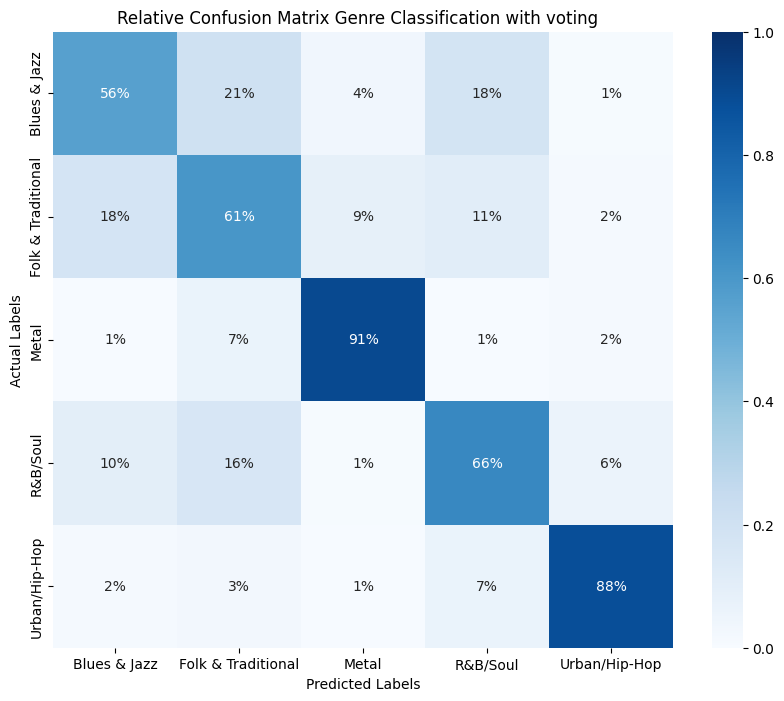

Average Accuracy: 72.9


In [65]:

# Training Voting Classifier
accuracy = train_classifier(df=merged_new, class_balance=True, print_report=True, title="Genre Classification with voting", k_folds=5,
    ensemble_method='voting')

print("Average Accuracy:", accuracy)

--- Fold 1/5 ---
Fold 1 - Accuracy: 0.75, Precision: 0.75, Recall: 0.75, F1-score: 0.75, AUC: 0.93
--- Fold 2/5 ---
Fold 2 - Accuracy: 0.77, Precision: 0.77, Recall: 0.77, F1-score: 0.77, AUC: 0.94
--- Fold 3/5 ---
Fold 3 - Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1-score: 0.78, AUC: 0.94
--- Fold 4/5 ---
Fold 4 - Accuracy: 0.75, Precision: 0.75, Recall: 0.75, F1-score: 0.75, AUC: 0.93
--- Fold 5/5 ---
Fold 5 - Accuracy: 0.77, Precision: 0.77, Recall: 0.77, F1-score: 0.77, AUC: 0.94

Average Accuracy across 5 folds: 0.76
                    precision    recall  f1-score   support

      Blues & Jazz       0.68      0.62      0.65       180
Folk & Traditional       0.66      0.72      0.69       181
             Metal       0.91      0.92      0.92       181
          R&B/Soul       0.70      0.70      0.70       181
     Urban/Hip-Hop       0.89      0.88      0.89       181

          accuracy                           0.77       904
         macro avg       0.77      0.77     

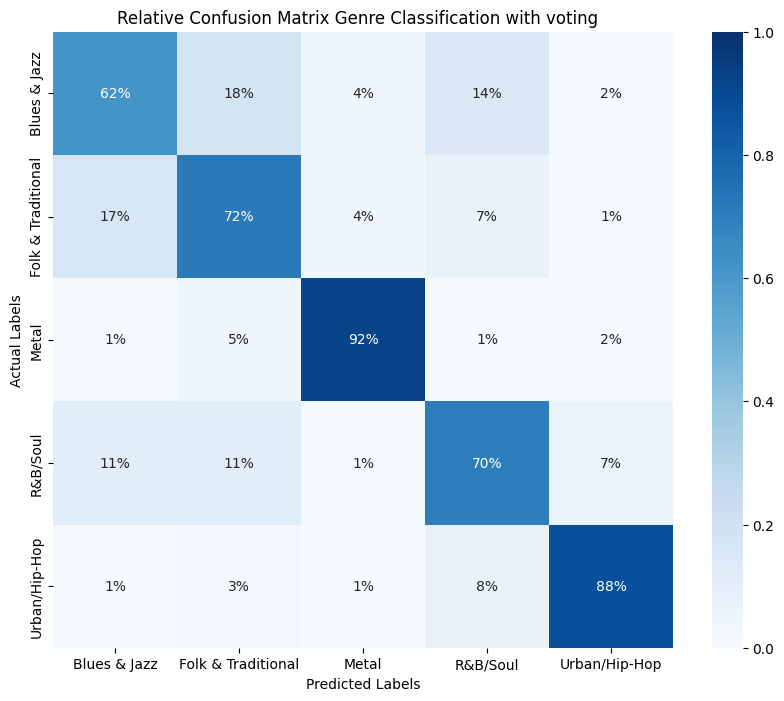

Average Accuracy: 76.2


In [66]:

# Training Stacking Classifier
accuracy = train_classifier(df=merged_new, class_balance=True, print_report=True, title="Genre Classification with Stacking", k_folds=5,
    ensemble_method='stacking')

print("Average Accuracy:", accuracy)

------------------------ **End** ------------------------